# Simulated LSST Impactor Catalog Calculation

mjuric, September 2019.

In [1]:
## Disable threading, so that benchmarks are single-core
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from collections import namedtuple

In [3]:
from astropy.coordinates import Angle

# Field of view to test
lsstFoV = np.deg2rad(1.8)

## Load Impactor Dataset

In [4]:
# Add extra paths to custom versions of various packages
import sys, os

os.environ['OORB_DATA'] = '/Users/mjuric/projects/lsst_ssp/oorb-lynne/data'

extra_paths = [
    '/Users/mjuric/projects/lsst_ssp/oorb-lynne/python',
]
for _p in extra_paths:
    if _p not in sys.path:
        sys.path += [ _p ]
        print(f"Added {_p}")

Added /Users/mjuric/projects/lsst_ssp/oorb-lynne/python


In [5]:
import os 
import sys
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord

In [6]:
import pyoorb as oo
from orbits import Orbits, PyOrbEphemerides

# FIXME: these are useful for pyoorb (and should really be in pyoorb)
oo.UTC, oo.UT1, oo.TT, oo.TAI = 1, 2, 3, 4
oo.CAR, oo.COM, oo.KEP, oo.DEL, oo.EQX = 1, 2, 3, 4, 5

# Initialize oorb. Very important. You will get '0's as earth positions otherwise.
# FIXME: the try/except construct ensures oorb_init is called only once. Calling it more than once messes up oorb.
#        This should be fixed in oorb.
try:
    oorb_initialized
except NameError:
    ephfile = os.path.join(os.getenv('OORB_DATA'), 'de430.dat')
    errcode = oo.pyoorb.oorb_init(ephfile)
    assert errcode == 0
    oorb_initialized = True

### Utilities

In [7]:
def to_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def eclToEqu(ecl):
    # ecliptic coordinate system defined with IAU1976 obliquity
    # Match OpenOrb and https://lambda.gsfc.nasa.gov/toolbox/tb_coordconv.cfm
    #
    # ecl.shape must be (3, ncoords)
    eps = np.deg2rad(23.43929111111111)
    cos_eps, sin_eps = np.cos(eps), np.sin(eps)
    
    R = np.zeros((3,3))
    R[0, :] = [1, 0, 0]
    R[1, :] = [0, cos_eps, -sin_eps]
    R[2, :] = [0, sin_eps, cos_eps]

    equ = np.matmul(R, ecl)

    return equ

### Load visits

In [8]:
# FIXME: force the user to specify the timescale for visit time
class Survey:
    def __init__(self, raVis, decVis, mjdVis, fovVis):
        # Convert visit ra,dec to unit vectors
        self.sc = SkyCoord(ra=raVis, dec=decVis, distance=1, unit=('deg', 'deg', 'au'))
        self.vec = self.sc.cartesian.xyz.value
        self.t = mjdVis
        # FIXME: this shouldn't be necessary (use np.argwhere)
        self.i = np.arange(0, len(mjdVis))
        self.fov = fovVis

    def __len__(self):
        return len(self.sc)

    def from_opsim_db(opsdbfile, fov, constraint=''):
        # Read the data you need for generating moving object positions from an opsim database
        # opsdbfile = '/epyc/projects/sssc/common/opsim_fbs1.2/baseline_1exp_pairsmix_10yrs.db'
        # constraint = ''
        #constraint = 'night <= 50'
        #constraint = 'night = 30'
        opsimdata, colmap = mLo.readOpsim(opsdbfile, constraint=constraint, footprint='circle')

        raCol, decCol, mjdCol = "fieldRA", "fieldDec", "observationStartMJD"

        return Survey(opsimdata[raCol], opsimdata[decCol], opsimdata[mjdCol], fov)

    def from_txt(fn, fov, sep='\t', nrows=None):
        # generated from opsim files using:
        # sqlite3 lsst_171year_test.db.new
        # select fieldRa as ra, fieldDec as dec, observationStartMJD + visitTime/2 as mjd, filter, visitTime, visitExposureTime, seeingFwhmEff, fiveSigmaDepth from summaryallprops;
        import pandas as pd
        df = pd.read_csv(fn, sep=sep, nrows=nrows, usecols=['ra', 'dec', 'mjd'])

        return Survey(df['ra'].values, df['dec'].values, df['mjd'].values, fov)

survey = Survey.from_txt('171year.csv.gz', fov=lsstFoV, sep=',')

print("number of visits:       %d" % len(survey))
print("min/max time of visit:  %.6f %.6f" % (survey.t.min(), survey.t.max()))

number of visits:       40514265
min/max time of visit:  29693.563324 92103.000000


### Load asteroids

In [9]:
# Read some test orbits
orb = Orbits()
orb.readOrbits('impactors.des.txt')

print("number of orbits:     %d" % len(orb))
print("min/max orbit epoch:  %.6f %.6f" % (orb.orbits['epoch'].min(), orb.orbits['epoch'].max()))

number of orbits:     10006
min/max orbit epoch:  55003.572000 91860.638000


#### Compute state vectors at regular intervals

In [10]:
def _compute_observer_position(obscode, t):
    # calculate Earth position vectors (cartesian, ecliptic) at requested times
    _ed = np.empty((len(t), 2))
    _ed[:, 0] = t
    _ed[:, 1] = oo.TT
    earthPos, err = oo.pyoorb.oorb_observer(in_obscode=obscode, in_date_ephems=_ed)
    assert err == 0

    return earthPos

def _compute_topocentric_unit_vectors(xv, obsPos):
    # shift origin to topocentric
    asts = xv[:, 1:4, :] - obsPos.T[1:4]

    # normalize the vector to 1
    norms = np.sqrt((asts*asts).sum(axis=1))
    asts /= norms[:, np.newaxis, :]

    # rotate to equatorial coordinate system
    astsEqu = np.rollaxis(eclToEqu(np.rollaxis(asts, 1, 0).reshape(3, -1)).reshape(3, asts.shape[0], asts.shape[2]), 1, 0)

    if True: # validation
        # rotate to equatorial coordinates
        testidx = 1 # 21

        _t = eclToEqu(asts[testidx, :, 1])
        assert (np.abs(_t - astsEqu[testidx, :, 1]) < 1e-15).all()

        # make sure all vectors are still properly normalized (unit vectors)
        assert (np.abs(np.square(astsEqu).sum(axis=1) - 1.) < 1e-15).all()

    return astsEqu

def _compute_on_sky_motion(asts):
    # compute the on-sky rate of motion
    import numpy.linalg as la
    r0 = asts[:, :, 0:-1]
    r0 = np.insert(r0, 0, np.nan, axis=2)
    r1 = asts

    # how much the asteroid could have moved in _previous_ night
    # note that the 0th element is NaN, as we don't have any info on how much it could have moved.
    sinDeltas = la.norm(np.cross(r0, r1, axis=1), axis=1)
    cosDeltas = (r0*r1).sum(axis=1)
    astsDelta = np.arctan2(sinDeltas, cosDeltas)
    
    return astsDelta, sinDeltas, cosDeltas

class StateGrid:
    def _propagate(self, state0, t, tmin=-np.inf, tmax=np.inf):
        # Generate states at each night on a grid defined by t. Work backwards.
        # For each asteroid, only propagate between tmin and tmax; set all other states to (0, 0, 0, 0, 0, 0)
        states = []
        state = state0.copy()

        # convert to oorb format
        _ed = np.empty((len(t), 2))
        _ed[:, 0], _ed[:, 1] = t, oo.TT

        for i, t in enumerate(np.flip(_ed, axis=0)):
            _active = (tmin <= t[0]) & (t[0] < tmax)
            _state = state[_active]

            if i % 10000 == 0:
                print((i, t[0], sum(_active)))

            if len(_state):
                _state, err = oo.pyoorb.oorb_propagation(in_orbits=_state, in_dynmodel='N', in_epoch=t)
                assert err == 0
                assert (_state[:, 8] == t[0]).all()
                state[_active] = _state

            _outstate = state.copy()
            _outstate[~_active, 1:4] = 0 # hide these asteroids are in the Sun, post impact
            _outstate[:, 8] = t[0]

            states.append(_outstate)

        # merge and reformat the array into the expected shape of (nast x 6 x nnights)
        states.reverse()
        states = np.rollaxis(np.stack(states), 0, 3)
        return states

    def _propagate_aux(self, st):
        return self._propagate(st[0], self.t, tmax=st[1])

    def __init__(self, orbits, tmin, tmax, obscode='I11', ncores=None, nchunks=3):
        self.orbits = orbits
        
        # orbits to work on
        pyeph = PyOrbEphemerides()
        pyeph.setOrbits(orbits)
        pyeph.convertOrbitFormat('CAR')
        # FIXME: we shouldn't be saving this... Nothing should be relying on it...
        self.pyeph = pyeph

        # min/max time to cover
        tmin, tmax = np.floor(tmin - 1), np.ceil(tmax + 1)
        self.t = t = np.arange(tmin, tmax + 1, 1.)

        # propagate
        # FIXME: tmax = ... is a hack for B612 impactor work; the interface should be generalized.
        if ncores is None:
            ncores = os.cpu_count() or 1

        if ncores == 1:
            states = self._propagate(pyeph.oorbElem, t, tmax=pyeph.oorbElem[:, 8])
        else:
            from multiprocessing import Pool

            elem_chunks = to_chunks(pyeph.oorbElem, nchunks)
            tmax_chunks = to_chunks(pyeph.oorbElem[:, 8], nchunks)

            with Pool(processes=ncores) as pool:
                states = np.concatenate(list(pool.map(self._propagate_aux, zip(elem_chunks, tmax_chunks))))
        # FIXME: this is not just xv, but full oorb state record -- should find a better name for it
        self.xv = states

        # Ephemerides:
        # Observer radius-vector (ICRS)
        self.obsPos = _compute_observer_position(obscode, t)
        # Topocentric equatorial unit vector
        self.vec = _compute_topocentric_unit_vectors(self.xv, self.obsPos)
        # On-sky motion
        self.delta, self.sinDelta, self.cosDelta = _compute_on_sky_motion(self.vec)

        # FIXME: this should go into IndexedSurvey.query()
        #assert tast[0] < tvisits.min()
        #assert tast[-1] > tvisits.max()

In [11]:
%%time

#states = StateGrid(orb[0::400][:5], survey.t.min(), survey.t.max(), 'I11', nchunks=3)
states = StateGrid(orb[0::10], survey.t.min(), survey.t.max(), 'I11', nchunks=10)

print("state vector grid computed over times:  %.6f to %.6f" % (states.t.min(), states.t.max()))

(0, 92104.0, 0)
(0, 92104.0, 0)
(0, 92104.0, 0)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(10000, 82104.0, 0)
(10000, 82104.0, 0)
(10000, 82104.0, 0)
(20000, 72104.0, 0)
(20000, 72104.0, 10)
(20000, 72104.0, 10)
(20000, 72104.0, 10)
(30000, 62104.0, 10)
(30000, 62104.0, 10)
(30000, 62104.0, 10)
(30000, 62104.0, 10)
(40000, 52104.0, 10)
(40000, 52104.0, 10)
(40000, 52104.0, 10)
(40000, 52104.0, 10)
(50000, 42104.0, 10)
(50000, 42104.0, 10)
(50000, 42104.0, 10)
(50000, 42104.0, 10)
(60000, 32104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(20000, 72104.0, 0)
(60000, 32104.0, 10)
(60000, 32104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(20000, 72104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(60000, 32104.0, 10)
(30000, 62104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(20000, 72104.0, 10)
(30000, 62104.0, 10)
(20000, 72104.0, 10)
(40000, 52104.0, 10)
(30000, 62104.0, 10)
(40000, 52104.0, 10)
(30000, 62104.0, 10)
(50000, 42104.0, 10)
(40000, 52104.0, 10)
(50000, 42104.0, 10)
(40000, 52104.0, 10)


(0, 92104.0, 0)
(40000, 52104.0, 10)
(60000, 32104.0, 10)
(50000, 42104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 10)
(50000, 42104.0, 10)
(10000, 82104.0, 10)
(20000, 72104.0, 10)
(60000, 32104.0, 10)
(0, 92104.0, 0)
(60000, 32104.0, 10)
(20000, 72104.0, 10)
(30000, 62104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(10000, 82104.0, 10)
(20000, 72104.0, 0)
(30000, 62104.0, 0)
(30000, 62104.0, 10)
(40000, 52104.0, 10)
(40000, 52104.0, 10)
(20000, 72104.0, 10)
(40000, 52104.0, 10)
(50000, 42104.0, 10)
(50000, 42104.0, 10)
(30000, 62104.0, 10)
(50000, 42104.0, 10)
(60000, 32104.0, 10)
(60000, 32104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(20000, 72104.0, 0)
(30000, 62104.0, 0)
(40000, 52104.0, 10)
(0, 92104.0, 0)
(10000, 82104.0, 0)
(20000, 72104.0, 0)
(30000, 62104.0, 0)
(60000, 32104.0, 10)
(40000, 52104.0, 10)
(0, 92104.0, 0)
(40000, 52104.0, 10)
(50000, 42104.0, 10)
(10000, 82104.0, 10)
(50000, 42104.0, 10)
(50000, 42104.0, 10)
(60000, 32104.0, 10)
(0, 92104.0, 0)
(20000, 72104.0, 10)

In [147]:
assert np.all(states.xv == states0.xv)

In [14]:
import pickle
with open("states.pkl", "wb") as fp:
    pickle.dump(states, fp, protocol=4)

## Visualize the dataset

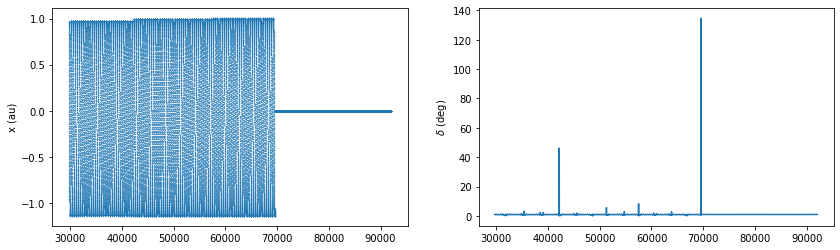

In [15]:
import matplotlib.pyplot as plt
def _plot_ast(states, idx):
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(states.xv[idx, 8], states.xv[idx, 1], s=0.1)
    ax.set_ylabel("x (au)")
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(states.t, np.rad2deg(states.delta[idx]))
    ax.set_ylabel(r"$\delta$ (deg)")

_plot_ast(states, 0)

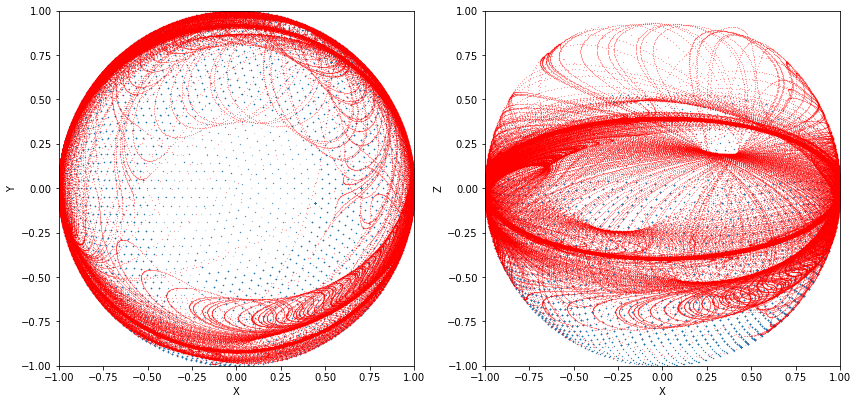

In [16]:
def _visualize(survey, states):
    visits = survey.vec
    asts = states.vec

    # subsample visits, to make the plot look reasonable
    rnd.seed(42)
    aidx = rnd.choice(asts.shape[0], 5)
    idx = rnd.choice(survey.vec.shape[1], 50_000)

    fig = plt.figure(figsize=(14,7))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.scatter(visits[0, idx], visits[1, idx], s=0.01)
    ax.scatter(asts[aidx, 0], asts[aidx, 1], s=0.02, c='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax = fig.add_subplot(1, 2, 2)
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.scatter(visits[0, idx], visits[2, idx], s=0.01)
    ax.scatter(asts[aidx, 0], asts[aidx, 2], s=0.02, c='red')
    ax.set_xlabel('X')
    ax.set_ylabel('Z');

_visualize(survey, states)

In [20]:
states.delta[None]

array([[[       nan, 0.01761144, 0.01756002, ..., 0.01777826,
         0.01777485, 0.01777133],
        [       nan, 0.00310765, 0.00303362, ..., 0.01777826,
         0.01777485, 0.01777133],
        [       nan, 0.01793148, 0.01793381, ..., 0.01777826,
         0.01777485, 0.01777133],
        ...,
        [       nan, 0.00762096, 0.00759061, ..., 0.01777826,
         0.01777485, 0.01777133],
        [       nan, 0.00507944, 0.0050563 , ..., 0.01777826,
         0.01777485, 0.01777133],
        [       nan, 0.02274415, 0.0224362 , ..., 0.01777826,
         0.01777485, 0.01777133]]])

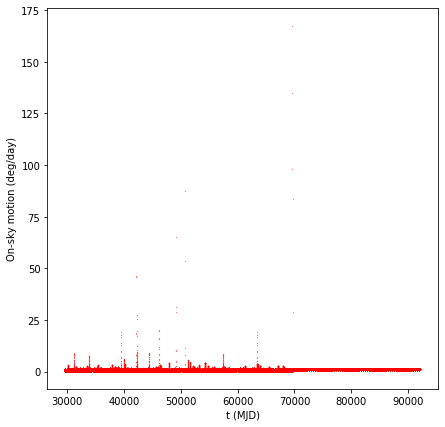

In [27]:
def _plot_sky_motion(states, idx=None):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1, 1, 1)

    deltaDeg = np.rad2deg(states.delta[idx])
    ax.scatter(np.broadcast_to(states.t, deltaDeg.shape), deltaDeg, s=0.04, c='red')

    ax.set_xlabel('t (MJD)')
    ax.set_ylabel('On-sky motion (deg/day)');

# plot the on-sky motion of a subset of objects
_plot_sky_motion(states, slice(0, 5))

## Test 0: Compute/Load Ground Truth

The ground truth are the ephemerides of all asteroids propagated at the exact epochs of all visits (~3M visits).

In [171]:
%%time
# Compute positions at exact visit times, for every visit. This is _very_
# computationally expensive, so we save the result for future re-use.

cachefn = 'impactors-ephems-5.ndarray'
computeCache = False

nast = len(states.pyeph.oorbElem)
ntimes = len(survey.t)

if computeCache:
    _pyeph = PyOrbEphemerides()
    _pyeph.setOrbits(orb[0:1])
    _pyeph.convertOrbitFormat('CAR')

    # output array (nast x ntimes x 2)
    fp = np.memmap(cachefn, dtype='float64', mode='w+', shape=(nast, ntimes, 2))

    # generate impactor ephemerides, object by object, up to state vector epoch
    for k in range(len(pyeph.oorbElem)):
        _pyeph.oorbElem[0:1] = states.pyeph.oorbElem[k]
        _active = tvisits < _pyeph.oorbElem[0, 8]
        _active, = np.nonzero(_active)
#        _active = _active[-200000:]
        _tvisits = tvisits[_active]
        print(k, len(_tvisits), ' t=', _tvisits[-1])
        ephems = _pyeph.generateEphemerides(_tvisits, timeScale='TT')
        fp[k, _active, 0] = ephems[0, :]['ra']
        fp[k, _active, 1] = ephems[0, :]['dec']
        print('  geodist=', ephems['geo_dist'][0, -1])

    del fp

if True:
    # read from mmapped array
    fp = np.memmap(cachefn, dtype='float64', mode='r', shape=(nast, ntimes, 2))
    raEph = fp[:, :, 0]
    decEph = fp[:, :, 1]

CPU times: user 907 µs, sys: 1.58 ms, total: 2.48 ms
Wall time: 15.9 ms


In [174]:
np.searchsorted(states.t, survey.t[25878665])

39842

In [193]:
# Debug a particular asteroid, visit, time combination
#iast, ivis, it = 27, 30, 1
#iast, ivis, it = 0, 13565, 18
##iast, ivis, it = 0, 1200109, 1808
##iast, ivis, it = 0, 5931008, 9082
##iast, ivis, it = 0, 38043650, 58619
iast, ivis, it = 0, 25878665, 39842

# Compare the exactly-calculated separation to the approximate one
astPos = SkyCoord(ra=raEph[iast][ivis], dec=decEph[iast][ivis], unit='deg')
visPos = SkyCoord(ra=raVis[ivis], dec=decVis[ivis], unit='deg')
print('Exact:')
print('radec vis  =', raVis[ivis], decVis[ivis])
print('radec ast  =', raEph[iast][ivis], decEph[iast][ivis])
print('visPos     =', visPos.cartesian.xyz.value, 't=', survey.t[ivis])
print('astPos     =', astPos.cartesian.xyz.value, 't=', survey.t[ivis])
print('exact sep  =', astPos.separation(visPos).degree, 'deg')
print()

print('Approximate:')
print('vis        = ', survey.vec[:, ivis], 't=', survey.t[ivis])
print('asts       = ', states.vec[iast][:, it], 't=', states.t[it])
print('approx sep = ', np.rad2deg(np.arccos((states.vec[iast][:, it] * survey.vec[:, ivis]).sum())), 'deg')
print('search rad = ', np.rad2deg(np.arccos(cosRfov*states.cosDelta[iast, it] - sinRfov*states.sinDelta[iast, it])), 'deg' )

Exact:
radec vis  = 104.658778 -22.267310000000002
radec ast  = 192.49774559906936 -50.549143517869
visPos     = [-0.23419014  0.89530351 -0.37892822] t= 69533.4677964762
astPos     = [-0.62035966 -0.13750482 -0.77216987] t= 69533.4677964762
exact sep  = 71.65303864933 deg

Approximate:
vis        =  [-0.23419014  0.89530351 -0.37892822] t= 69533.4677964762
asts       =  [0.97442384 0.20617524 0.08938648] t= 69534.0
approx sep =  94.44385133495689 deg
search rad =  136.47270958187767 deg


In [204]:
# Compute the `truth` -- a list of visits where each asteroid was imaged.
def compute_truth(survey, raEph, decEph):
    truth = []
    for _ra, _dec in zip(raEph, decEph):
        _valid = (_ra != 0) & (_dec != 0)
        _ra, _dec = _ra[_valid], _dec[_valid]
        astSc = SkyCoord(ra=_ra, dec=_dec, unit='deg')
        sep = survey.sc[_valid].separation(astSc)
        truth += [ survey.i[_valid][sep.radian < survey.fov] ]
    return truth

truth = compute_truth(survey, raEph, decEph)
list(map(len, truth))[:10]

[3179, 3261, 3230, 8704, 4453]

In [38]:
# [13706, 14148, 16762]
# [3179, 3261, 3230, 8704, 4453]

## Test 1: Direct dot product

Algorithm:
* For each visit, find the corresponding asteroid observation (the closest one _after_ the visit time)
* Compute `cosR`, the maximum radius in which the asteroid could have moved between the observations. This is the asteroid motion plus FoV radius. We assume the path between points has been approximately linear.
* Compute the dot product of all fields and the corresponding asteroids.
* Keep only those with the `product > cosR`

In [224]:
%%time
class DotProductIndex:
    def __init__(self, survey, states):
        self.survey = survey
        self.i = np.searchsorted(states.t, survey.t)

    def query(self, states):
        i, survey = self.i, self.survey

        z = []
        cosRfov, sinRfov = np.cos(survey.fov), np.sin(survey.fov)
        for ast, cosDelta, sinDelta in zip(states.vec, states.cosDelta, states.sinDelta):
            # get asteroid position-vector at nearest time not less then time of each visit
            # shape: (3, nvisits)
            astvis = ast[:, i]

            # get the on-sky distance the asteroid could have covered
            # around the time this visit was taken
            cosR = cosRfov*cosDelta[i] - sinRfov*sinDelta[i]

            # keep only plausable visits
            z += [ survey.i[ (survey.vec*astvis).sum(axis=0) >= cosR ] ]
        return z

dotIndex = DotProductIndex(survey, states)
found_dot = dotIndex.query(states)

CPU times: user 13.7 s, sys: 6.88 s, total: 20.6 s
Wall time: 21.1 s


In [225]:
list(map(len, found_dot))

[7457, 5321, 4523, 11550, 7399]

In [226]:
# [7457, 5321, 4523, 11550, 7399]

In [227]:
def _is_subset_of_truth(found, truth):
    # validate truth is a subset of these
    for ii, (zz, tt) in enumerate(zip(found, truth)):
        assert set(tt) <= set(zz), (len(set(tt)), len(set(zz)), set(zz) - set(tt))
    zzsum = sum(map(len, found))
    ttsum = sum(map(len, truth))
    print("Overlapping visit candidates:", zzsum)
    print("Exact overlaps:", ttsum)
    print("Efficiency: %.2f" % (ttsum / zzsum))

_is_subset_of_truth(found_dot, truth)

Overlapping visit candidates: 36250
Exact overlaps: 22827
Efficiency: 0.63


In [ ]:
%%timeit
dotIndex.query(states)

## Test 2: Search Trees

Algorithm:
* Assumptions:
  * Asteroids ephemeris are all computed at the same time (note: doesn't have to be at equal intervals).
* Prepare:
  * Divide visits into groups, one per nights
  * For each group, create a 3D search tree on unit vectors representing the visits (BallTrees seem to work best)
* Search:
  * Compute `searchR`, the 3D search radius corresponding to angle each asteroid could have moved
  * For each night:
    * Run an objects-within-radius search (for all asteroids at once)
  * Return a lists of potential visit IDs, one list per asteroid

In [115]:
%%time

from sklearn.neighbors import KDTree, BallTree
import numpy.linalg as la

class TreeIndex(object):
    tree = None

    def __init__(self, survey, dt = 1., toffs = 0.0):
        t0 = np.floor(survey.t.min()) - toffs
        t1 = np.ceil(survey.t.max()) + dt

        nightT = np.arange(t0, t1, dt)
        nightRanges = np.searchsorted(survey.t, nightT)
        
        # build an array of KDTrees for each visit, one per interval
        tree = []
        for idx in range(0, len(nightT)-1):
            start, end = nightRanges[idx:idx+2]
            xnight = survey.vec.T[start:end]
            xt = survey.t[start:end]
            if len(xt):
                assert((nightT[idx] <= xt.min()) & (xt.max() < nightT[idx+1]))
                tr = BallTree(xnight, leaf_size=25)
            else:
                tr = None
            tree += [ ( tr, start, nightT[idx], nightT[idx+1] ) ]
        tree += [ (None, nightRanges[-1], nightT[-1], np.inf) ]
        
        self.nightT = nightT
        self.dt = dt
        self.tree = tree
        self.survey = survey

    def query(self, states, ncores=None):
        asts, tast, astsDelta = states.vec, states.t, states.delta
        tree, nightT, dt, Rfov = self.tree, self.nightT, self.dt, self.survey.fov

        # the algorithm is in its own function so we don't have to be re-creating
        # the object and rebuilding the class while interactivelly changing it while
        # developing/debugging.
        return _tree_query_aux(asts, tast, astsDelta, tree, nightT, dt, Rfov, ncores)

vtree = TreeIndex(survey)

CPU times: user 14.8 s, sys: 6.88 s, total: 21.7 s
Wall time: 29.5 s


In [158]:
def _tree_query_aux(asts, tast, astsDelta, tree, nightT, dt, Rfov, ncores):
    # check the inputs are OK
    # 1. there has to be at least one ephem per night
    assert np.all(np.diff(tast) <= dt)
    # 2. ephems must cover all nights
    assert tast[0] < tree[0][2]
    assert tast[-1] < tree[-1][3]

    searchR = 2.*np.sin(0.5*(Rfov + astsDelta))

    # divide up the asteroid ephemeris into "nights"
    # allows for more than one ephem per night
    astTimeRanges = np.searchsorted(tast, nightT, side='right')

    global _global_state
    _global_state = (astTimeRanges, asts, tast, tree, nightT, dt, searchR)

    def _run(mapfunc):
        found = [[] for _ in asts ]

        import time
        t0 = time.time()
        for at, matches in enumerate(mapfunc(_tree_query_aux_mapper, range(len(nightT)))):
            if at > 0 and at % 365*5 == 0:
                frac = at/len(nightT)

                t1 = time.time()
                dt = (t1 - t0) / 60. # time in minutes
                dtr = dt/frac - dt # time remaining

                print(f"Processed {at/365} survey years ({frac*100:.1f}%) in {dt:.1f} minutes ({dtr:.1f} remaining)")
            for i, th in matches.items():
                found[i].append(th)

        found = [ np.concatenate(f) for f in found ]
        return found

    if ncores is None:
        ncores = os.cpu_count() or 1

    if ncores == 1:
        found = _run(map)
    else:
        from multiprocessing import Pool
        with Pool(processes=ncores) as pool:
            found = _run(pool.imap_unordered)

    return found

_global_state = None
def _tree_query_aux_mapper(night):
    astTimeRanges, asts, tast, tree, nightT, dt, searchR = _global_state
    t = nightT[night]

    found = {}

    tr, offs, t0, t1 = tree[night]
    dtvis = t1 - t0
    assert t0 <= t < t1
    if tr is None:
        return {}

    start, end = astTimeRanges[night:night+2]
    # all asteroid ephemeris must fall into this "night"
    assert t0 < tast[start] and tast[end-1] <= t1

    for idx in range(start, end):
        ta, tb = tast[idx-1], tast[idx]
        dtast = tb - ta
        this = offs + tr.query_radius(asts[:, :, idx], r=searchR[:, idx])
        for i, th in enumerate(this):
            if not len(th):
                continue
            # keep only those in a valid time range for this asteroid
            if dtast < dtvis: # w/o this if, the subsequent line almost doubles the runtime (!)
                th = th[(ta < survey.t[th]) & (survey.t[th] <= tb)]
            found[i] = th.copy()

    return found

In [161]:
%%time

found = vtree.query(states, ncores=None)

validate = False
if validate:
    _is_subset_of_truth(found, truth)
else:
    print("WARNING: Validation turned off.")

Processed 1.0 survey years (0.6%) in 0.0 minutes (2.0 remaining)
Processed 2.0 survey years (1.2%) in 0.0 minutes (2.1 remaining)
Processed 3.0 survey years (1.8%) in 0.0 minutes (2.0 remaining)
Processed 4.0 survey years (2.3%) in 0.0 minutes (1.9 remaining)
Processed 5.0 survey years (2.9%) in 0.1 minutes (1.8 remaining)
Processed 6.0 survey years (3.5%) in 0.1 minutes (1.8 remaining)
Processed 7.0 survey years (4.1%) in 0.1 minutes (1.7 remaining)
Processed 8.0 survey years (4.7%) in 0.1 minutes (1.7 remaining)
Processed 9.0 survey years (5.3%) in 0.1 minutes (1.7 remaining)
Processed 10.0 survey years (5.8%) in 0.1 minutes (1.7 remaining)
Processed 11.0 survey years (6.4%) in 0.1 minutes (1.7 remaining)
Processed 12.0 survey years (7.0%) in 0.1 minutes (1.7 remaining)
Processed 13.0 survey years (7.6%) in 0.1 minutes (1.6 remaining)
Processed 14.0 survey years (8.2%) in 0.1 minutes (1.6 remaining)
Processed 15.0 survey years (8.8%) in 0.2 minutes (1.6 remaining)
Processed 16.0 surv

Processed 124.0 survey years (72.5%) in 1.3 minutes (0.5 remaining)
Processed 125.0 survey years (73.1%) in 1.3 minutes (0.5 remaining)
Processed 126.0 survey years (73.7%) in 1.4 minutes (0.5 remaining)
Processed 127.0 survey years (74.3%) in 1.4 minutes (0.5 remaining)
Processed 128.0 survey years (74.9%) in 1.4 minutes (0.5 remaining)
Processed 129.0 survey years (75.4%) in 1.4 minutes (0.5 remaining)
Processed 130.0 survey years (76.0%) in 1.4 minutes (0.4 remaining)
Processed 131.0 survey years (76.6%) in 1.4 minutes (0.4 remaining)
Processed 132.0 survey years (77.2%) in 1.4 minutes (0.4 remaining)
Processed 133.0 survey years (77.8%) in 1.4 minutes (0.4 remaining)
Processed 134.0 survey years (78.4%) in 1.4 minutes (0.4 remaining)
Processed 135.0 survey years (79.0%) in 1.4 minutes (0.4 remaining)
Processed 136.0 survey years (79.5%) in 1.5 minutes (0.4 remaining)
Processed 137.0 survey years (80.1%) in 1.5 minutes (0.4 remaining)
Processed 138.0 survey years (80.7%) in 1.5 minu

In [162]:
list(map(len, found[:10]))

[7457, 4955, 4144, 7854, 4825, 10243, 11028, 10042, 7923, 10161]

In [242]:
# [7457, 5321, 4523, 11550, 7399]
# [7457, 4955, 4144, 7854, 4825, 10243, 11028, 10042, 7923, 10161]

In [48]:
%%timeit
vtree.query(states)

5.75 s ± 56.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [166]:
# verify thata single-threaded result returns the same as a multi-threaded result.
# assumes you've run the query in a single thread and stored the result as found0
assert len(found0) == len(found)
for f0, f1 in zip(found0, found):
    assert set(f0) == set(f1)

## Exact computation

Given a list of candidate overlapping visits, compute the exact asteroid ephemerides at those times and keep only those that actually overlap the visits.

In [31]:
def compute_ephemeris_slow(oorbElem):
    # ground truth -- compute the same thing with the "classical" ephem calculator
    # and verify the results are bitwise identical
    ephems = np.empty((len(oorbElem), 11))
    for idx, _ in enumerate(oorbElem):
        ephems[idx], err = oo.pyoorb.oorb_ephemeris_basic(oorbElem[idx:idx+1, :12], 
                                                in_obscode='I11', in_dynmodel='N',
                                               in_date_ephems=oorbElem[idx:idx+1, 12:14])
        assert err == 0
    return ephems

In [95]:
%%time

_global_survey = None
_global_states = None
def _compute_exact_matches_single(item):
    survey, states = _global_survey, _global_states
    i, vv = item

    # vv: indicies of candidate intersecting visits
    ##tv, ravv, decvv = survey.t[vv], survey.sc.ra[vv], survey.sc.dec[vv]  # time, ra, dec of candidate visits
    tv = survey.t[vv]

    # Find indices of state vectors closest in time to the candidate visits
    tast = states.xv[i, 8]
    idx = np.searchsorted(tast, tv) - 1
    assert np.all(idx >= 0)

    # construct input arrays for propagation and propagate them to exact visit times
    oorbElem = np.zeros([len(vv), 14], dtype=np.double, order='F')
    oorbElem[:, :12] = states.xv[i, :12, idx]
    oorbElem[:, 12] = tv
    oorbElem[:, 13] = oo.TT
    eph = compute_ephemeris_slow(oorbElem)

    # find which asteroids actually overlap the visits
    visSc = survey.sc[vv] # SkyCoord(ra=ravv, dec=decvv, unit='deg')
    astSc = SkyCoord(ra=eph[:, 1], dec=eph[:, 2], unit='deg')
    sep = visSc.separation(astSc)
    didhit = sep.radian < survey.fov

    return vv[didhit], eph[didhit]

def compute_exact_matches(found, survey, states, ncores=None):
    # construct a partial function that will only take a single arg, so we
    # can call map on it. This is not because I want everyone to learn functional programming,
    # (which you should :-) ), but because it makes it trivial to replace map with Pool.map for
    # and make the result multi-threaded
    ##from functools import partial
    ##_compute_matches = partial(_compute_exact_matches_single, survey=survey, states=states)

    # a trick to prevent multiprocessing.pool from trying to pickle survey and states (which can be huge)
    global _global_survey, _global_states
    _global_survey, _global_states = survey, states

    # See https://stackoverflow.com/a/7558990 if you're not familiar with the
    # list_1, list_2 = zip(*list_of_pairs) idiom
    _do_matches = lambda mapfunc, found: zip(*mapfunc(_compute_exact_matches_single, enumerate(found[:100])))

    if ncores is None:
        ncores = os.cpu_count() or 1

    if ncores == 1:
        hit, ephhit = _do_matches(map, found)
    else:
        from multiprocessing import Pool
        with Pool(processes=ncores) as pool:
            hit, ephhit = _do_matches(pool.map, found)

    return hits, ephems

hits, ephems = compute_exact_matches(found, survey, states)
print(list(map(len, hits[:10])))

[3182, 3509, 1409, 4657, 2018, 5447, 8569, 8010, 5508, 7653]
CPU times: user 118 ms, sys: 176 ms, total: 294 ms
Wall time: 1min 16s


In [ ]:
# [3182, 3509, 1409, 4657, 2018, 5447, 8569, 8010, 5508, 7653]

In [280]:
from astropy.time import Time
from astropy.coordinates import Angle

def plot_deltas(t, sep, geo_dist):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    fig.suptitle(f"Asteroid #{i}")

    ax1.scatter(t.mjd, sep.arcsec, s=0.1)
    ax1.set_ylim(0, 1.1*sep.arcsec.max())
    ax1.set_ylabel("Δpos [arcsec]")

    ax2.scatter(s1.obstime.mjd, geo_dist, s=0.1)
    ax2.set_xlabel("time [mjd]")
    ax2.set_ylabel("geocentric distance [au]")

def _is_identical_to_truth(survey, found, truth, hits, ephems):
    for i, (hit, ephem, vv, truthHit) in enumerate(zip(hits, ephems, found, truth)):
        # compare to directly propagated ephems
        s1 = SkyCoord(ra=ephem[:, 1],  dec=ephem[:, 2],   obstime=Time(ephem[:, 0],  format='mjd', scale='tt'), unit='deg')
        s2 = SkyCoord(ra=raEph[i, hit], dec=decEph[i, hit], obstime=Time(survey.t[hit],  format='mjd', scale='tt'),  unit='deg')
        sep = s1.separation(s2)
        dt = s2.obstime - s1.obstime

        # --- FIXME: remove all hits where truth table hasn't been computed
        hit = hit[raEph[i, hit] != 0.]
        keep = s2.ra != 0.
        sep, dt = sep[keep], dt[keep]
        # --- FIXME

        if len(vv):
            imax = np.argmax(sep.arcsec)
            msg  = f"Asteroid #{i} found in {len(hit)} out of {len(vv)} candidate visits ({round(100*len(hit)/len(vv), 2)}%)"
            msg += "\n            max(Δpos) = %.2e arcsec at vis=%d, t=%s, geo_dist=%.2e au" % (sep.arcsec.max(), vv[imax], s1.obstime[imax], ephem[imax, 8])
            print(msg)
        else:
            print(f"Asteroid #{i} not imaged.")

        # uncomment to get a plot of differences
        # plot_deltas(s1.obstime, sep, ephem[:, 8])

        #plt.scatter(ephem[:, 8], sep.arcsec, s=0.1)
        #plt.xscale('log')
        #plt.suptitle(f'Asteroid #{i}')

        verify = True
        if verify:
            # verification: have we found all visits as given by the truth table?
            assert set(truthHit) == set(hit), set(truthHit) - set(hit)

            # verification: make sure there are no differences relative to directly propagated ephems
            assert np.all(dt == 0), f"Max differences vs truth: Δt = {dt.max()}"
            assert np.all(sep < Angle(2., unit='arcsec')), f"Max differences vs truth: Δpos = {sep.arcsecond.max()} arcsec"

_is_identical_to_truth(survey, found, truth, hits, ephems)

Asteroid #0 found in 3179 out of 7457 candidate visits (42.63%)
            max(Δpos) = 1.99e+00 arcsec at vis=1571962, t=35413.824227211604, geo_dist=9.13e-02 au
Asteroid #1 found in 3261 out of 5321 candidate visits (61.29%)
            max(Δpos) = 1.01e-02 arcsec at vis=9938091, t=54583.0901575872, geo_dist=3.31e-02 au
Asteroid #2 found in 3230 out of 4523 candidate visits (71.41%)
            max(Δpos) = 1.00e-03 arcsec at vis=6554342, t=44711.3423869338, geo_dist=9.46e-02 au
Asteroid #3 found in 8704 out of 11550 candidate visits (75.36%)
            max(Δpos) = 7.31e-03 arcsec at vis=10769116, t=51284.4000649947, geo_dist=2.36e-01 au
Asteroid #4 found in 4453 out of 7399 candidate visits (60.18%)
            max(Δpos) = 2.85e-01 arcsec at vis=1036153, t=32815.6176647116, geo_dist=3.95e-02 au


In [52]:
%%timeit
hits, ephems = compute_exact_matches(found, survey, states)

6.91 s ± 77.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Store output to files

In [52]:
states.orbits.orbits["objId"].loc[0]

3901

In [58]:
import pandas as pd

def to_df(states, hits, ephems):
    dfs = []
    objId = states.orbits.orbits["objId"]
    for i, (hit, ephem) in enumerate(zip(hits, ephems)):
        print(f"Asteroid {i}, objId={objId.loc[i]}: {len(hits)} observations")
        df = pd.DataFrame(ephem)
        df.columns = 'mjd ra dec vra vdec phase solarElon helioD geoD Vmag true_anomaly'.split()
        df['H'] = states.xv[i, :, 0][10]
        df['G'] = states.xv[i, :, 0][11]
        df.insert(0, 'visitIdx', hit)
        df.insert(0, 'objId', objId.loc[i])
        dfs += [df]
    return pd.concat(dfs)

# FIXME: make the output prettier -- sane number of decimal places, aligned columns
df = to_df(states, hits, ephems)
df.to_csv('catalog.txt', index=False, sep=' ')

Asteroid 0, objId=3901: 1001 observations
Asteroid 1, objId=3911: 1001 observations
Asteroid 2, objId=3921: 1001 observations
Asteroid 3, objId=3931: 1001 observations
Asteroid 4, objId=3941: 1001 observations
Asteroid 5, objId=3951: 1001 observations
Asteroid 6, objId=3961: 1001 observations
Asteroid 7, objId=3971: 1001 observations
Asteroid 8, objId=3981: 1001 observations
Asteroid 9, objId=3991: 1001 observations
Asteroid 10, objId=4001: 1001 observations
Asteroid 11, objId=4011: 1001 observations
Asteroid 12, objId=4021: 1001 observations
Asteroid 13, objId=4031: 1001 observations
Asteroid 14, objId=4041: 1001 observations
Asteroid 15, objId=4051: 1001 observations
Asteroid 16, objId=4061: 1001 observations
Asteroid 17, objId=4071: 1001 observations
Asteroid 18, objId=4081: 1001 observations
Asteroid 19, objId=4091: 1001 observations
Asteroid 20, objId=4101: 1001 observations
Asteroid 21, objId=4111: 1001 observations
Asteroid 22, objId=4121: 1001 observations
Asteroid 23, objId=41

Asteroid 212, objId=6021: 1001 observations
Asteroid 213, objId=6031: 1001 observations
Asteroid 214, objId=6041: 1001 observations
Asteroid 215, objId=6051: 1001 observations
Asteroid 216, objId=6061: 1001 observations
Asteroid 217, objId=6071: 1001 observations
Asteroid 218, objId=6081: 1001 observations
Asteroid 219, objId=6091: 1001 observations
Asteroid 220, objId=6101: 1001 observations
Asteroid 221, objId=6111: 1001 observations
Asteroid 222, objId=6121: 1001 observations
Asteroid 223, objId=6131: 1001 observations
Asteroid 224, objId=6141: 1001 observations
Asteroid 225, objId=6151: 1001 observations
Asteroid 226, objId=6161: 1001 observations
Asteroid 227, objId=6171: 1001 observations
Asteroid 228, objId=6181: 1001 observations
Asteroid 229, objId=6191: 1001 observations
Asteroid 230, objId=6201: 1001 observations
Asteroid 231, objId=6211: 1001 observations
Asteroid 232, objId=6221: 1001 observations
Asteroid 233, objId=6231: 1001 observations
Asteroid 234, objId=6241: 1001 o

Asteroid 417, objId=7471: 1001 observations
Asteroid 418, objId=7481: 1001 observations
Asteroid 419, objId=7491: 1001 observations
Asteroid 420, objId=7501: 1001 observations
Asteroid 421, objId=7511: 1001 observations
Asteroid 422, objId=7521: 1001 observations
Asteroid 423, objId=7531: 1001 observations
Asteroid 424, objId=7541: 1001 observations
Asteroid 425, objId=7551: 1001 observations
Asteroid 426, objId=7561: 1001 observations
Asteroid 427, objId=7571: 1001 observations
Asteroid 428, objId=7581: 1001 observations
Asteroid 429, objId=7591: 1001 observations
Asteroid 430, objId=7601: 1001 observations
Asteroid 431, objId=7611: 1001 observations
Asteroid 432, objId=7621: 1001 observations
Asteroid 433, objId=7631: 1001 observations
Asteroid 434, objId=7641: 1001 observations
Asteroid 435, objId=7651: 1001 observations
Asteroid 436, objId=7661: 1001 observations
Asteroid 437, objId=7671: 1001 observations
Asteroid 438, objId=7681: 1001 observations
Asteroid 439, objId=7691: 1001 o

Asteroid 614, objId=9441: 1001 observations
Asteroid 615, objId=9451: 1001 observations
Asteroid 616, objId=9461: 1001 observations
Asteroid 617, objId=9471: 1001 observations
Asteroid 618, objId=9481: 1001 observations
Asteroid 619, objId=9491: 1001 observations
Asteroid 620, objId=9501: 1001 observations
Asteroid 621, objId=9511: 1001 observations
Asteroid 622, objId=9521: 1001 observations
Asteroid 623, objId=9531: 1001 observations
Asteroid 624, objId=9541: 1001 observations
Asteroid 625, objId=9551: 1001 observations
Asteroid 626, objId=9561: 1001 observations
Asteroid 627, objId=9571: 1001 observations
Asteroid 628, objId=9581: 1001 observations
Asteroid 629, objId=9591: 1001 observations
Asteroid 630, objId=9601: 1001 observations
Asteroid 631, objId=9611: 1001 observations
Asteroid 632, objId=9621: 1001 observations
Asteroid 633, objId=9631: 1001 observations
Asteroid 634, objId=9641: 1001 observations
Asteroid 635, objId=9651: 1001 observations
Asteroid 636, objId=9661: 1001 o

Asteroid 823, objId=2125: 1001 observations
Asteroid 824, objId=2135: 1001 observations
Asteroid 825, objId=2145: 1001 observations
Asteroid 826, objId=2155: 1001 observations
Asteroid 827, objId=2165: 1001 observations
Asteroid 828, objId=2175: 1001 observations
Asteroid 829, objId=2185: 1001 observations
Asteroid 830, objId=2195: 1001 observations
Asteroid 831, objId=2205: 1001 observations
Asteroid 832, objId=2215: 1001 observations
Asteroid 833, objId=2225: 1001 observations
Asteroid 834, objId=2235: 1001 observations
Asteroid 835, objId=2245: 1001 observations
Asteroid 836, objId=2255: 1001 observations
Asteroid 837, objId=2265: 1001 observations
Asteroid 838, objId=2275: 1001 observations
Asteroid 839, objId=2285: 1001 observations
Asteroid 840, objId=2295: 1001 observations
Asteroid 841, objId=2305: 1001 observations
Asteroid 842, objId=2315: 1001 observations
Asteroid 843, objId=2325: 1001 observations
Asteroid 844, objId=2335: 1001 observations
Asteroid 845, objId=2345: 1001 o

### Direct integration vs. jumpy integration

Compare directly integrated asteroid to the "truth" value table.

In [207]:
_pyeph = PyOrbEphemerides()
_pyeph.setOrbits(orb[0:1])
_pyeph.convertOrbitFormat('CAR')

aidx, vidx = 0, 3702556
#aidx, vidx = 1, 1889288
#aidx, vidx = 2, 58814

_pyeph.oorbElem[0:1] = pyeph.oorbElem[aidx]
res = _pyeph.generateEphemerides(tvisits[vidx:vidx+1], timeScale='TT')

s1 = SkyCoord(ra=res[0]['ra'],      dec=res[0]['dec'], unit='deg')
s2 = SkyCoord(ra=raEph[aidx, vidx], dec=decEph[aidx, vidx],  unit='deg')
sep = s1.separation(s2)

print("Δt   =", tvisits[vidx] - res[0]['time'][0])
print("Δpos =", sep[0])

Δt   = 0.0
Δpos = 0d00m10.421s


Compare the positions of an asteroid calcuated directly, with the one calculated with stops inbetween.

In [209]:
_pyeph = PyOrbEphemerides()
_pyeph.setOrbits(orb[0:1])
_pyeph.convertOrbitFormat('CAR')

aidx, vidx = 0, 3702556
#aidx, vidx = 1, 1889288
#aidx, vidx = 2, 58814

_pyeph.oorbElem[0:1] = pyeph.oorbElem[aidx]
res1 = _pyeph.generateEphemerides(tvisits[vidx:vidx+1], timeScale='TT')[0]
_pyeph.oorbElem[0:1] = pyeph.oorbElem[aidx]
res2 = _pyeph.generateEphemerides(tvisits[vidx::1000], timeScale='TT')[0]

dt = res2[0]['time'] - res1[0]['time']
s1 = SkyCoord(ra=res1[0]['ra'],      dec=res1[0]['dec'], unit='deg')
s2 = SkyCoord(ra=res2[0]['ra'],      dec=res2[0]['dec'], unit='deg')
sep = s1.separation(s2)

assert dt == 0, dt
print("Δpos   =", sep)
print("nsteps =", len(res2))

Δpos   = 0d00m01.0952s
nsteps = 36812
